In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K

###OGP: https://doi.org/10.48550/arXiv.1804.03999

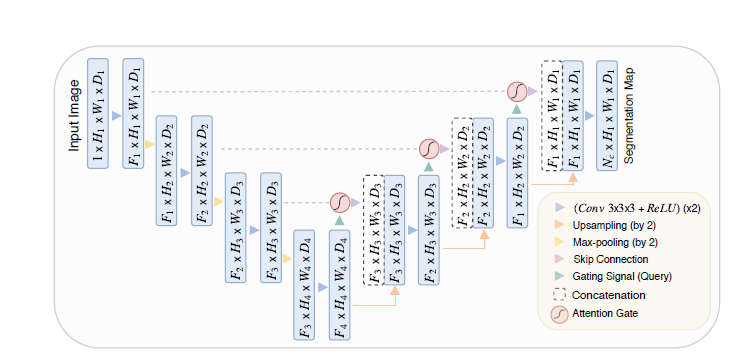

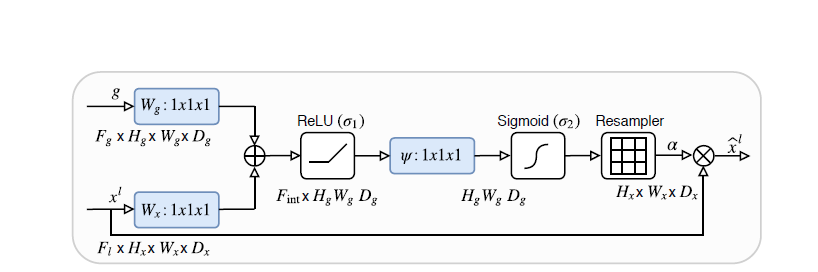

In [2]:
def conv_block(inputs, filters, kernel_size=3,):
    x = inputs
    for i in range(2):
        x = tf.keras.layers.Conv2D(filters, kernel_size, kernel_initializer="he_normal",
                                   padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)  # Apply BatchNorm
        x = tf.keras.layers.Activation("relu")(x)
    
    x = tf.keras.layers.Dropout(0.2)(x)
    return x

In [3]:
def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return tf.keras.layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [4]:
def gating_signal(inputs, filters,):
    x=tf.keras.layers.Conv2D(filters, kernel_size=1, kernel_initializer="he_normal", padding="same")(inputs)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Activation("relu")(x)
    return x

In [5]:
def attention_block(x, g, change_shape):
    shape_x = K.int_shape(x)
    theta_x= tf.keras.layers.Conv2D(change_shape, kernel_size=1, strides=2, kernel_initializer="he_normal", padding="same")(x)
    phi_g= tf.keras.layers.Conv2D(change_shape, kernel_size=1, strides=1, kernel_initializer="he_normal", padding="same")(g)
    add_xg=tf.keras.layers.add([phi_g, theta_x])
    act_xg= tf.keras.layers.Activation("relu")(add_xg)
    psi= tf.keras.layers.Conv2D(1, 1, padding="same", kernel_initializer="he_normal")(act_xg)
    sigmoid_psi= tf.keras.layers.Activation("sigmoid")(psi)
    upsample_psi= tf.keras.layers.UpSampling2D((2,2))(sigmoid_psi)
    upsample_psi = repeat_elem(upsample_psi, shape_x[3])
    y = tf.keras.layers.multiply([upsample_psi, x])
    y= tf.keras.layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    y= tf.keras.layers.BatchNormalization()(y)
    return y

In [6]:
def Attention_UNet(input_shape, NUM_CLASSES=1):
    '''
    Attention UNet, 
    
    '''
    # network structure
    filters = 64 # number of basic filters for the first layer
    
    
    inputs = tf.keras.layers.Input(input_shape, dtype=tf.float32)

    
    conv_1 = conv_block(inputs, filters, 3)
    pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

    conv_2 = conv_block(pool_1, 2*filters, 3)
    pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

    conv_3 = conv_block(pool_2, 4*filters, 3)
    pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_3)

    conv_4 = conv_block(pool_3, 8*filters, 3)
    pool_4 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_4)

    conv_5 = conv_block(pool_4, 16*filters, 3)

    
    gating_16 = gating_signal(conv_5, 8*filters)
    att_16 = attention_block(conv_4, gating_16, 8*filters)
    up_16 = tf.keras.layers.Conv2DTranspose(8*filters, kernel_size=3, strides=2, padding="same")(conv_5)
    up_16 = tf.keras.layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, 8*filters, 3)

    gating_32 = gating_signal(up_conv_16, 4*filters)
    att_32 = attention_block(conv_3, gating_32, 4*filters)
    up_32 = tf.keras.layers.Conv2DTranspose(4*filters, kernel_size=3, strides=2, padding="same")(up_conv_16)
    up_32 = tf.keras.layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, 4*filters, 3)

    gating_64 = gating_signal(up_conv_32, 2*filters)
    att_64 = attention_block(conv_2, gating_64, 2*filters)
    up_64 = tf.keras.layers.Conv2DTranspose(2*filters, kernel_size=3, strides=2, padding="same")(up_conv_32)
    up_64 = tf.keras.layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, 2*filters, 3)

    gating_128 = gating_signal(up_conv_64, filters)
    att_128 = attention_block(conv_1, gating_128, filters)
    up_128 = tf.keras.layers.Conv2DTranspose(filters, kernel_size=3, strides=2, padding="same")(up_conv_64)
    up_128 = tf.keras.layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128,filters, 3)

    # 1*1 convolutional layers
    conv_final = tf.keras.layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = tf.keras.layers.BatchNormalization(axis=3)(conv_final)
    conv_final = tf.keras.layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = tf.keras.models.Model(inputs, conv_final, name="Attention_UNet")
    return model

In [9]:
input_shape=(512, 512, 3)
model= Attention_UNet(input_shape, 1)
model.summary()

Model: "Attention_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_78 (Conv2D)             (None, 512, 512, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 512, 512, 64  256        ['conv2d_78[0][0]']              
 ormalization)                  )                                                    

 activation_68 (Activation)     (None, 64, 64, 512)  0           ['batch_normalization_60[0][0]'] 
                                                                                                  
 conv2d_85 (Conv2D)             (None, 64, 64, 512)  2359808     ['activation_68[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 64, 64, 512)  2048       ['conv2d_85[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_69 (Activation)     (None, 64, 64, 512)  0           ['batch_normalization_61[0][0]'] 
                                                                                                  
 dropout_21 (Dropout)           (None, 64, 64, 512)  0           ['activation_69[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 64, 64, 512)  0           ['batch_normalization_67[0][0]'] 
                                                                                                  
 dropout_23 (Dropout)           (None, 64, 64, 512)  0           ['activation_76[0][0]']          
                                                                                                  
 conv2d_95 (Conv2D)             (None, 64, 64, 256)  131328      ['dropout_23[0][0]']             
                                                                                                  
 batch_normalization_68 (BatchN  (None, 64, 64, 256)  1024       ['conv2d_95[0][0]']              
 ormalization)                                                                                    
          

                                8)                                'conv2d_103[0][0]']             
                                                                                                  
 activation_83 (Activation)     (None, 128, 128, 12  0           ['add_10[0][0]']                 
                                8)                                                                
                                                                                                  
 conv2d_105 (Conv2D)            (None, 128, 128, 1)  129         ['activation_83[0][0]']          
                                                                                                  
 activation_84 (Activation)     (None, 128, 128, 1)  0           ['conv2d_105[0][0]']             
                                                                                                  
 up_sampling2d_10 (UpSampling2D  (None, 256, 256, 1)  0          ['activation_84[0][0]']          
 )        

                                )                                 'dropout_18[0][0]']             
                                                                                                  
 conv2d_113 (Conv2D)            (None, 512, 512, 64  4160        ['multiply_11[0][0]']            
                                )                                                                 
                                                                                                  
 conv2d_transpose_11 (Conv2DTra  (None, 512, 512, 64  73792      ['dropout_25[0][0]']             
 nspose)                        )                                                                 
                                                                                                  
 batch_normalization_77 (BatchN  (None, 512, 512, 64  256        ['conv2d_113[0][0]']             
 ormalization)                  )                                                                 
          

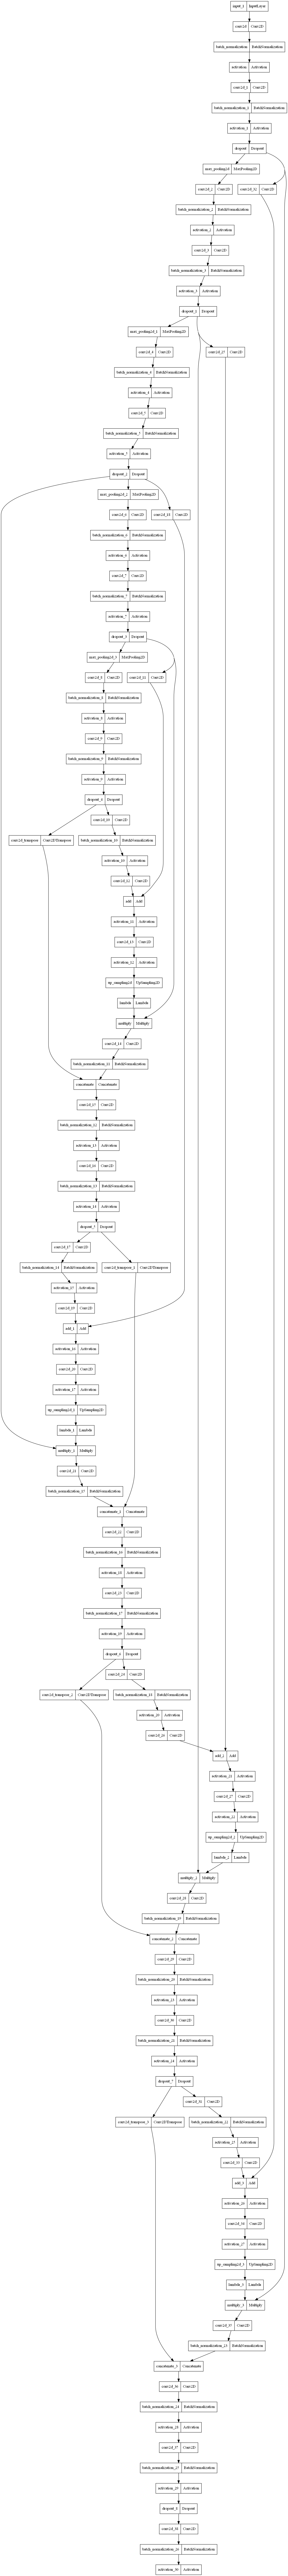

In [9]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)
